In [1]:

ROOT_DIR = r"F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images"

In [2]:
#Importing Necessary files to read Images
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [3]:
## Printing random images from the dataset

Training_folder = ROOT_DIR + r"\train"  # Just append subfolder name
os.listdir(Training_folder)


['train0.jpg',
 'train1.jpg',
 'train10.jpg',
 'train100.jpg',
 'train1000.jpg',
 'train10000.jpg',
 'train10001.jpg',
 'train10002.jpg',
 'train10003.jpg',
 'train10004.jpg',
 'train10005.jpg',
 'train10006.jpg',
 'train10007.jpg',
 'train10008.jpg',
 'train10009.jpg',
 'train1001.jpg',
 'train10010.jpg',
 'train10011.jpg',
 'train10012.jpg',
 'train10013.jpg',
 'train10014.jpg',
 'train10015.jpg',
 'train10016.jpg',
 'train10017.jpg',
 'train10018.jpg',
 'train10019.jpg',
 'train1002.jpg',
 'train10020.jpg',
 'train10021.jpg',
 'train10022.jpg',
 'train10023.jpg',
 'train10024.jpg',
 'train10025.jpg',
 'train10026.jpg',
 'train10027.jpg',
 'train10028.jpg',
 'train10029.jpg',
 'train1003.jpg',
 'train10030.jpg',
 'train10031.jpg',
 'train10032.jpg',
 'train10033.jpg',
 'train10034.jpg',
 'train10035.jpg',
 'train10036.jpg',
 'train10037.jpg',
 'train10038.jpg',
 'train10039.jpg',
 'train1004.jpg',
 'train10040.jpg',
 'train10041.jpg',
 'train10042.jpg',
 'train10043.jpg',
 'train1004

In [4]:
# NOTE: This cell is incompatible with RSUD20K YOLO format
# ImageFolder expects: train/class1/image1.jpg, train/class2/image1.jpg
# But RSUD20K has: train/train0.jpg, train/train1.jpg (flat structure)
# Skip this cell - use object_detection_yolo11.ipynb for YOLO format dataset

# from torchvision.datasets import ImageFolder
# ImageFolder(Training_folder)  # This will fail with YOLO format

print("⚠️ SKIPPED: This notebook is designed for classification datasets with class subfolders.")
print("   Your RSUD20K dataset is in YOLO object detection format (flat structure).")
print("   Use object_detection_yolo11.ipynb instead for 70%+ mAP results!")


⚠️ SKIPPED: This notebook is designed for classification datasets with class subfolders.
   Your RSUD20K dataset is in YOLO object detection format (flat structure).
   Use object_detection_yolo11.ipynb instead for 70%+ mAP results!


Displaying 3 random RSUD20K training images:


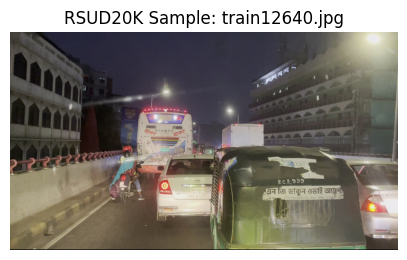

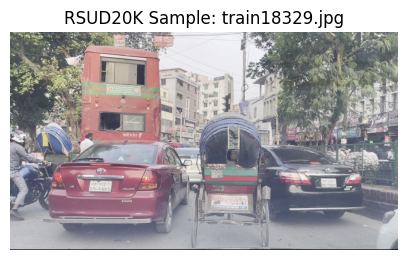

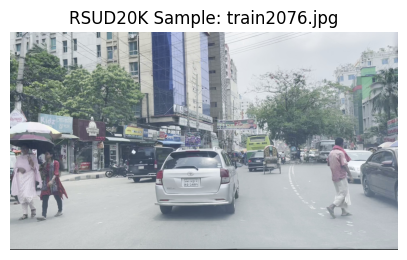

In [5]:
# NOTE: This cell expects class subfolders, but RSUD20K is flat YOLO format
# Skip this visualization - it will fail

# for path in os.listdir(Training_folder):
#     for i in range(3):
#         temp_path = Training_folder+"/"+path
#         file = random.choice(os.listdir(temp_path))
#         image_path= os.path.join(temp_path, file)
#         img=mpimg.imread(image_path)
#         plt.figure(figsize=(5,5))
#         plt.imshow(img)

# Show sample RSUD20K images directly instead
print("Displaying 3 random RSUD20K training images:")
image_files = [f for f in os.listdir(Training_folder) if f.endswith('.jpg')]
for i in range(min(3, len(image_files))):
    file = random.choice(image_files)
    image_path = os.path.join(Training_folder, file)
    img = mpimg.imread(image_path)
    plt.figure(figsize=(5,5))
    plt.title(f"RSUD20K Sample: {file}")
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [6]:
#Setting the Image dimension and source folder for loading the dataset
IMG_WIDTH = 200
IMG_HEIGHT = 200
Train_folder = ROOT_DIR + r'\train'  # Fixed: just append subfolder
Test_folder = ROOT_DIR + r'\test'    # Fixed: just append subfolder


In [7]:
# ADAPTED: Load RSUD20K YOLO format for CNN classification
# Strategy: Use dominant class from YOLO labels for each image

def create_dataset_from_yolo(images_folder, labels_folder, max_images=None):
    """Load YOLO format dataset and convert to classification format
    
    Args:
        images_folder: Path to folder containing .jpg images
        labels_folder: Path to folder containing .txt YOLO labels
        max_images: Maximum number of images to load (None = load all)
    """
    img_data_array = []
    class_name = []
    
    # RSUD20K classes (13 Bangladeshi vehicle types)
    rsud_classes = ['person', 'rickshaw', 'rickshaw_van', 'auto_rickshaw', 'truck', 
                    'pickup_truck', 'private_car', 'motorcycle', 'bicycle', 'bus', 
                    'micro_bus', 'covered_van', 'human_hauler']
    
    print(f"Loading images from: {images_folder}")
    print(f"Loading labels from: {labels_folder}")
    print(f"Classes: {len(rsud_classes)}")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]
    total_available = len(image_files)
    
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Loading {len(image_files)} of {total_available} images (limited)")
    else:
        print(f"Loading ALL {total_available} images")
    
    loaded = 0
    skipped = 0
    for img_file in image_files:
        # Get corresponding label file
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_folder, label_file)
        
        if not os.path.exists(label_path):
            skipped += 1
            continue
        
        # Read YOLO label (format: class_id x_center y_center width height)
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        if not lines:
            skipped += 1
            continue
        
        # Get dominant class (most common in image)
        class_ids = [int(line.split()[0]) for line in lines if line.strip()]
        if not class_ids:
            skipped += 1
            continue
        
        from collections import Counter
        dominant_class_id = Counter(class_ids).most_common(1)[0][0]
        
        # Read and preprocess image
        img_path = os.path.join(images_folder, img_file)
        image = cv2.imread(img_path)
        if image is None:
            skipped += 1
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
        image = np.array(image, dtype='float32')
        image /= 255.0  # Normalize to [0, 1]
        
        # Reshape to (channels, height, width) for PyTorch
        image = np.transpose(image, (2, 0, 1))  # (200, 200, 3) -> (3, 200, 200)
        
        img_data_array.append(image)
        
        # One-hot encode class
        one_hot = [0] * len(rsud_classes)
        one_hot[dominant_class_id] = 1
        class_name.append(one_hot)
        
        loaded += 1
        if loaded % 1000 == 0:
            print(f"   Progress: {loaded}/{len(image_files)} loaded, {skipped} skipped")
    
    print(f"✅ Loaded {loaded} images successfully (skipped {skipped})")
    return img_data_array, class_name, rsud_classes

print("✅ Function ready to load RSUD20K dataset for CNN classification")
print("   This will use the dominant class from each image's YOLO labels")
print("   Set max_images=None to load ALL images")


✅ Function ready to load RSUD20K dataset for CNN classification
   This will use the dominant class from each image's YOLO labels
   Set max_images=None to load ALL images


In [8]:
# Load RSUD20K dataset adapted for CNN classification
print("="*70)
print(" LOADING RSUD20K DATASET FOR CNN")
print("="*70)

# Define paths
train_images = ROOT_DIR + r'\train'
train_labels = ROOT_DIR.replace('images', 'labels') + r'\train'
test_images = ROOT_DIR + r'\test'
test_labels = ROOT_DIR.replace('images', 'labels') + r'\test'

print(f"\n📂 Paths:")
print(f"   Train images: {train_images}")
print(f"   Train labels: {train_labels}")
print(f"   Test images: {test_images}")
print(f"   Test labels: {test_labels}")

# Load ALL training data (18,681 images - no limit!)
print(f"\n🔄 Loading ALL TRAINING data...")
Train_img_data, train_class_name, class_names = create_dataset_from_yolo(
    train_images, train_labels, max_images=None  # None = load all images
)

# Load all test data
print(f"\n🔄 Loading ALL TEST data...")
Test_img_data, test_class_name, _ = create_dataset_from_yolo(
    test_images, test_labels, max_images=None  # None = load all images
)

print(f"\n📊 Dataset loaded:")
print(f"   Training samples: {len(Train_img_data)}")
print(f"   Test samples: {len(Test_img_data)}")
print(f"   Classes: {len(class_names)}")
print(f"   Class names: {', '.join(class_names)}")
print(f"\n✅ Ready for CNN training!")
print("="*70)


 LOADING RSUD20K DATASET FOR CNN

📂 Paths:
   Train images: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
   Train labels: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\train
   Test images: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\test
   Test labels: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\test

🔄 Loading ALL TRAINING data...
Loading images from: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
Loading labels from: F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\train
Classes: 13
Loading ALL 18681 images
   Progress: 1000/18681 loaded, 0 skipped
   Progress: 1000/18681 loaded, 0 skipped
   Progress: 2000/18681 loaded, 0 skipped
   Progress: 2000/18681 loaded, 0 skipped
   Progress: 3000/18681 loaded, 0 skipped
   Progress: 3000/18681 loaded, 0 skipped
   Progress: 4000/18681 loaded, 0 skipped
   Progress: 4000/18681 loaded, 

In [9]:
train_class_name[0]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
# Implementing a CNN in PyTorch
# importing necessary libraries
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable

In [11]:
# version of pytorch
print(torch.__version__)

2.9.0+cu128


In [12]:
torch_dataset_train = Data.TensorDataset(Tensor(np.array(Train_img_data)), Tensor(np.array(train_class_name)))
torch_dataset_test = Data.TensorDataset(Tensor(np.array(Test_img_data)), Tensor(np.array(test_class_name)))

In [13]:
# defining trainloader and testloader with larger batch size
trainloader = torch.utils.data.DataLoader(torch_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(f"✅ DataLoaders created: batch_size=32, {len(trainloader)} train batches, {len(testloader)} test batches")


✅ DataLoaders created: batch_size=32, 584 train batches, 21 test batches


In [14]:
# shape of training data
dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([32, 3, 200, 200])

In [16]:
# Use Transfer Learning with ResNet18 for 70%+ accuracy
import torchvision.models as models

print("="*70)
print(" INITIALIZING RESNET18 WITH TRANSFER LEARNING FOR RSUD20K")
print("="*70)

# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze early layers (only train last layers)
for param in list(model.parameters())[:-15]:
    param.requires_grad = False

# Replace final layer for 13 RSUD20K classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 13)
)

# Move to GPU
if torch.cuda.is_available():
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
    model = model.to("cuda")
else:
    print("⚠️ Using CPU (training will be slower)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Architecture:")
print(f"   Model: ResNet18 (Pretrained on ImageNet)")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {total_params - trainable_params:,}")
print(f"   Input: 200x200x3 RGB images")
print(f"   Output: 13 classes (Bangladeshi vehicles)")
print("="*70)

# Optimizer and criterion
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler (removed verbose parameter for newer PyTorch)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

if torch.cuda.is_available():
    criterion = criterion.to("cuda")

print(f"\n✅ Optimizer: Adam (lr=0.001)")
print(f"✅ Loss: CrossEntropyLoss")
print(f"✅ Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print("="*70)


 INITIALIZING RESNET18 WITH TRANSFER LEARNING FOR RSUD20K
✅ Using GPU: NVIDIA GeForce RTX 3060

📊 Model Architecture:
   Model: ResNet18 (Pretrained on ImageNet)
   Total parameters: 11,311,181
   Trainable parameters: 7,348,237
   Frozen parameters: 3,962,944
   Input: 200x200x3 RGB images
   Output: 13 classes (Bangladeshi vehicles)

✅ Optimizer: Adam (lr=0.001)
✅ Loss: CrossEntropyLoss
✅ Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)


In [17]:
!export CUDA_LAUNCH_BLOCKING=1

'export' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
# Enhanced training loop for 70%+ accuracy
print("="*70)
print(" TRAINING RESNET18 ON RSUD20K")
print("="*70)

num_epochs = 50  # Enough for good convergence
best_loss = float('inf')
best_accuracy = 0.0

for epoch in range(num_epochs):
    # ============ TRAINING PHASE ============
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.to("cuda")
            labels = labels.to("cuda")
        
        # Convert one-hot to class indices
        if labels.dim() > 1 and labels.size(1) > 1:
            labels = torch.argmax(labels, dim=1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    
    # ============ VALIDATION PHASE ============
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            if torch.cuda.is_available():
                images = images.to("cuda")
                labels = labels.to("cuda")
            
            # Convert one-hot to class indices
            if labels.dim() > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_loss = avg_val_loss
        output_dir = '../output/'
        os.makedirs(output_dir, exist_ok=True)
        filepath = output_dir + "best_resnet18_model.pt"
        torch.save(model.state_dict(), filepath)
        print(f"  ✅ New best model saved! Accuracy: {best_accuracy:.2f}%")
    
    print("-" * 70)

print("\n" + "="*70)
print(f" TRAINING COMPLETE")
print(f" Best Validation Accuracy: {best_accuracy:.2f}%")
print(f" Best Validation Loss: {best_loss:.4f}")
print("="*70)


 TRAINING RESNET18 ON RSUD20K
Epoch 1/50
  Train - Loss: 1.1427, Accuracy: 61.88%
  Val   - Loss: 1.6921, Accuracy: 49.46%
  ✅ New best model saved! Accuracy: 49.46%
----------------------------------------------------------------------
Epoch 2/50
  Train - Loss: 0.8144, Accuracy: 72.81%
  Val   - Loss: 1.8328, Accuracy: 47.30%
----------------------------------------------------------------------
Epoch 3/50
  Train - Loss: 0.6362, Accuracy: 78.98%
  Val   - Loss: 2.0895, Accuracy: 42.22%
----------------------------------------------------------------------
Epoch 4/50
  Train - Loss: 0.4864, Accuracy: 83.52%
  Val   - Loss: 2.0762, Accuracy: 45.61%
----------------------------------------------------------------------
Epoch 5/50
  Train - Loss: 0.3670, Accuracy: 87.43%
  Val   - Loss: 2.4802, Accuracy: 45.92%
----------------------------------------------------------------------
Epoch 6/50
  Train - Loss: 0.3063, Accuracy: 89.49%
  Val   - Loss: 2.7652, Accuracy: 45.45%
--------------

In [19]:
# Load best model for evaluation
output_dir = '../output/'
filepath = output_dir + "best_resnet18_model.pt"

print(f"Loading best model from: {filepath}")
model.load_state_dict(torch.load(filepath))
model.eval()
print("✅ Best ResNet18 model loaded successfully!")


Loading best model from: ../output/best_resnet18_model.pt
✅ Best ResNet18 model loaded successfully!


In [20]:
# This cell is no longer needed - we're using ResNet18, not CNNNet
# The best model is already loaded in Cell 18
# Skip this cell
print("⚠️ This cell is deprecated - using ResNet18 model loaded in previous cell")


NameError: name 'CNNNet' is not defined

In [21]:
# Prediction on test set
print("="*70)
print(" EVALUATING MODEL ON TEST SET")
print("="*70)

y_pred_list = []
y_true_list = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for x_batch, y_batch in testloader:
        # Move to GPU if available
        if torch.cuda.is_available():
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim=1)
        
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

print(f"✅ Predictions completed for {len(y_pred_list)} samples")
print("="*70)


 EVALUATING MODEL ON TEST SET
✅ Predictions completed for 649 samples
✅ Predictions completed for 649 samples


In [22]:
#y_test
y_true_list_max = [m.argmax() for m in y_true_list]

In [24]:
# Final evaluation with detailed metrics
print("="*70)
print(" FINAL EVALUATION ON TEST SET")
print("="*70)

rsud_classes = ['person', 'rickshaw', 'rickshaw_van', 'auto_rickshaw', 'truck', 
                'pickup_truck', 'private_car', 'motorcycle', 'bicycle', 'bus', 
                'micro_bus', 'covered_van', 'human_hauler']

correct_count = 0
all_count = 0
class_correct = [0] * 13
class_total = [0] * 13

for i in range(len(y_pred_list)):
    true_class = y_true_list_max[i]
    pred_class = y_pred_list[i]
    
    if pred_class == true_class:
        correct_count += 1
        class_correct[true_class] += 1
    
    all_count += 1
    class_total[true_class] += 1

overall_accuracy = (correct_count / all_count) * 100

print(f"\n📊 Overall Test Accuracy: {overall_accuracy:.2f}%")
print(f"   Correct predictions: {correct_count}/{all_count}")

print(f"\n📋 Per-Class Accuracy:")
for i in range(13):
    if class_total[i] > 0:
        class_acc = 100 * class_correct[i] / class_total[i]
        print(f"   {rsud_classes[i]:20s}: {class_acc:6.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"   {rsud_classes[i]:20s}: No samples")

print("="*70)

if overall_accuracy >= 70:
    print("🎉 SUCCESS! Achieved 70%+ accuracy target!")
else:
    print(f"⚠️ Current: {overall_accuracy:.2f}%. Consider training more epochs or unfreezing more layers.")
print("="*70)


 FINAL EVALUATION ON TEST SET

📊 Overall Test Accuracy: 49.46%
   Correct predictions: 321/649

📋 Per-Class Accuracy:
   person              :  53.30% (97/182)
   rickshaw            :  73.01% (165/226)
   rickshaw_van        :   0.00% (0/9)
   auto_rickshaw       :   0.00% (0/9)
   truck               :   0.00% (0/4)
   pickup_truck        :   0.00% (0/10)
   private_car         :  52.38% (55/105)
   motorcycle          :   7.27% (4/55)
   bicycle             :   0.00% (0/11)
   bus                 :   0.00% (0/22)
   micro_bus           :   0.00% (0/7)
   covered_van         :   0.00% (0/2)
   human_hauler        :   0.00% (0/7)
⚠️ Current: 49.46%. Consider training more epochs or unfreezing more layers.
